In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
from models import ACNetwork

torch.manual_seed(0)
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device ="cpu"

## Create an actor-critic model
uses 33 inputs, 4 outputs and and 64 units per hidden layer

In [2]:
# Create model
network = ACNetwork(33,4,64).double().to(device)

# uncomment to train with pre-trained model
#network.load_state_dict(torch.load("savedata/ppo_trained.save"))
#network.train();

## Load Unity environment and get properties

In [3]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher', no_graphics=True)

# get env info
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name] 
num_agents = len(env_info.agents)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## Train a PPO agent

In [4]:
# PPO parameters
ratio_clip = 0.2
max_grad_norm = 0.5
tmax = 300
max_episodes = 800
ppo_epochs = 5
batchsize = 500
discount = 0.98
optimizer = torch.optim.Adam(network.parameters(), 3e-4, eps=1e-5)

print_every = 10

# list to contain mean scores
history = []

for episode in range(1, max_episodes+1):
    
    # prepare environment
    env_info = env.reset(train_mode=True)[brain_name] 
    states = env_info.vector_observations
    scores = 0
    episode_done = False
    
    while not episode_done:
        rewards_list = []
        states_list = []
        actions_list = []
        log_probs_list = []
        values_list = []
        
        # collect trajectories
        for i in range(tmax):
            states = torch.tensor(states).to(device)
            actions, log_probs, values = network.forward(states)
            env_info = env.step(actions.cpu().clamp(-1,1).numpy())[brain_name]
            new_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            scores += np.mean(rewards)
            
            if np.any(dones):
                # ends episode if any agent reaches terminal state
                episode_done = True

            rewards_list.append(rewards)
            states_list.append(states)
            actions_list.append(actions.cpu().detach().numpy())
            log_probs_list.append(log_probs.cpu().detach().numpy())
            values_list.append(values.cpu().detach().numpy())

            states = new_states        

        rewards_list = np.asarray(rewards_list)
        values_list = np.asarray(values_list).squeeze()
        returns = values.cpu().detach().numpy().squeeze()
        future_rewards_list = np.zeros(rewards_list.shape)
        advantages_list = np.zeros(rewards_list.shape)
        
        # calculate advantages
        for i in reversed(range(len(rewards_list))):
            returns = rewards_list[i] + discount*returns
            advantages = returns - values_list[i]
            future_rewards_list[i] = returns
            advantages_list[i] = advantages
         
        # normalize advantages
        advantages_list = np.asarray(advantages_list)
        advantages_list = (advantages_list - advantages_list.mean()) / (advantages_list.std() + 1e-5)
        
        # put everything in data format that can be fed to DataLoader object
        rollout = []
        for i_time in range(len(rewards_list)):
            for i_agent in range(num_agents):

                data = [torch.tensor(states_list[i_time][i_agent]).to(device),
                        torch.tensor(actions_list[i_time][i_agent]).to(device),
                        torch.tensor(log_probs_list[i_time][i_agent]).to(device),
                        torch.tensor(future_rewards_list[i_time][i_agent]).double().to(device),
                        torch.tensor([advantages_list[i_time][i_agent]]).double().to(device) ]
                rollout.append( data )
    
        # prevent training on tiny trajectories
        if len(rollout) < batchsize*2:
            continue
        
        # object to load data batch-wise
        dataloader = DataLoader(rollout, batch_size=batchsize,
                            shuffle=True, num_workers=0)  
        
        # train using ppo for several epochs
        for ppo_epoch in range(ppo_epochs):
            for minibatch in dataloader:
                # load training batch
                sample_states, sample_actions, old_log_probs, sample_returns, sample_advantages = minibatch
                
                # get log_probs for current network state
                actions, log_probs, values = network.forward(sample_states, sample_actions)                
                
                # compute r and clipped surrogate function for action loss
                ratio = torch.exp(log_probs - old_log_probs)
                obj = ratio * sample_advantages
                obj_clipped = ratio.clamp(1.0 - ratio_clip, 1.0 + ratio_clip) * sample_advantages
                action_loss = -torch.min(obj, obj_clipped).mean()
                
                # copmpute value loss using MSE
                value_loss = 0.5 * (sample_returns-values).pow(2).mean()
                
                optimizer.zero_grad()
                (action_loss + value_loss).backward()
                
                # clip gradients and perform optimization
                nn.utils.clip_grad_norm_(network.parameters(), max_grad_norm)
                optimizer.step()                
                
    history.append(scores)
    mean_reward = np.mean(history[-100:])
    if episode % print_every == 0 or mean_reward > 30:
        print("\rEpisode %d: \t Avg reward per agent: %f \t Avg over last 100 episodes: %f" % (episode, scores, mean_reward))
        torch.save(network.state_dict(), "savedata/ppo_ep%d.save" % episode)
    else:
        print("\rEpisode %d: \t Avg reward per agent: %f \t Avg over last 100 episodes: %f" % (episode, scores, mean_reward), end="")
    
    if mean_reward > 30:
        # solve condition: average score +30 over 100 episodes
        torch.save(network.state_dict(), "savedata/ppo_trained.save")
        print("\nEnvironment solved. Saved network to savedata folder.")
        break

Episode 10: 	 Avg reward per agent: 2.841000 	 Avg over last 100 episodes: 1.403950
Episode 20: 	 Avg reward per agent: 5.570500 	 Avg over last 100 episodes: 3.020025
Episode 30: 	 Avg reward per agent: 9.283000 	 Avg over last 100 episodes: 4.666433
Episode 40: 	 Avg reward per agent: 12.519500 	 Avg over last 100 episodes: 6.255637
Episode 50: 	 Avg reward per agent: 17.237500 	 Avg over last 100 episodes: 8.045560
Episode 60: 	 Avg reward per agent: 22.221000 	 Avg over last 100 episodes: 10.145500
Episode 70: 	 Avg reward per agent: 23.873999 	 Avg over last 100 episodes: 12.150764
Episode 80: 	 Avg reward per agent: 26.830499 	 Avg over last 100 episodes: 13.920381
Episode 90: 	 Avg reward per agent: 28.550999 	 Avg over last 100 episodes: 15.400216
Episode 100: 	 Avg reward per agent: 26.886999 	 Avg over last 100 episodes: 16.693310
Episode 110: 	 Avg reward per agent: 33.148499 	 Avg over last 100 episodes: 19.434490
Episode 120: 	 Avg reward per agent: 28.964999 	 Avg over la

## Close environment

In [5]:
env.close()

## Plot scores

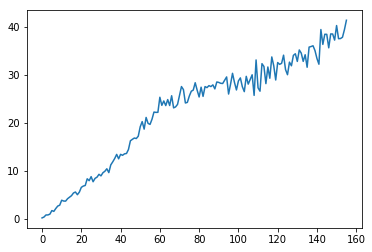

In [6]:
plt.plot(history)